In [1]:
%matplotlib widget

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
max_rewards = 2.5e9

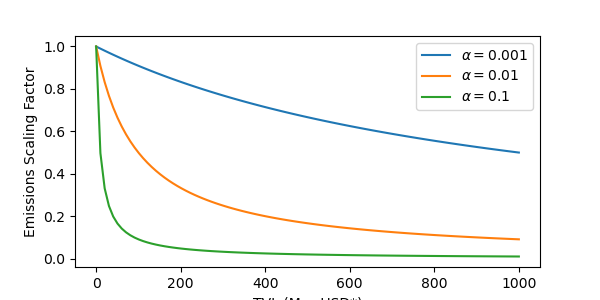

In [4]:
# plot the inverse tvl emissions mechanism
TVL = np.linspace(0, 1000, 100)
alpha_vec = np.asarray([0.001, 0.01, 0.1])

plt.figure(figsize=(6, 3))

for alpha in alpha_vec:
    f = 1 / (1 + alpha * TVL)
    plt.plot(TVL, f, label=f'$\\alpha={alpha}$')

plt.xlabel('TVL (M-csUSD*)')
plt.ylabel('Emissions Scaling Factor')
plt.legend()
plt.show()
plt.tight_layout()
plt.savefig('inverse_tvl_emissions_mechanism.png', dpi=300)

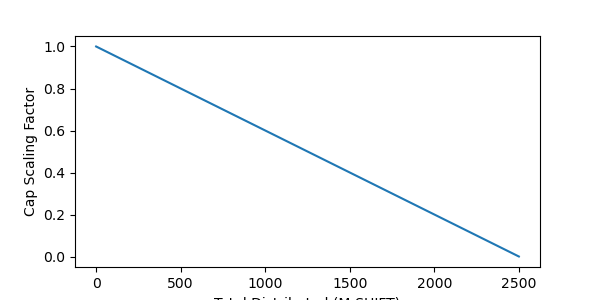

In [29]:
# define the cap function
total_minted = np.linspace(0, max_rewards, 100)
g = 1 - total_minted / max_rewards
plt.figure(figsize=(6, 3))
plt.plot(total_minted/1e6, g)
plt.xlabel('Total Distributed (M-SHIFT)')
plt.ylabel('Cap Scaling Factor')
plt.show()
plt.tight_layout()
plt.savefig('cap_function.png', dpi=300)


alpha: 1e-05
[       0.           199600.79840319   397213.47818198 ...
 71487979.58516061 71493164.2820445  71498347.5846126 ]
[0.00000000e+00 1.99600798e+05 3.96846013e+05 ... 1.13432599e+08
 1.13442534e+08 1.13452464e+08]


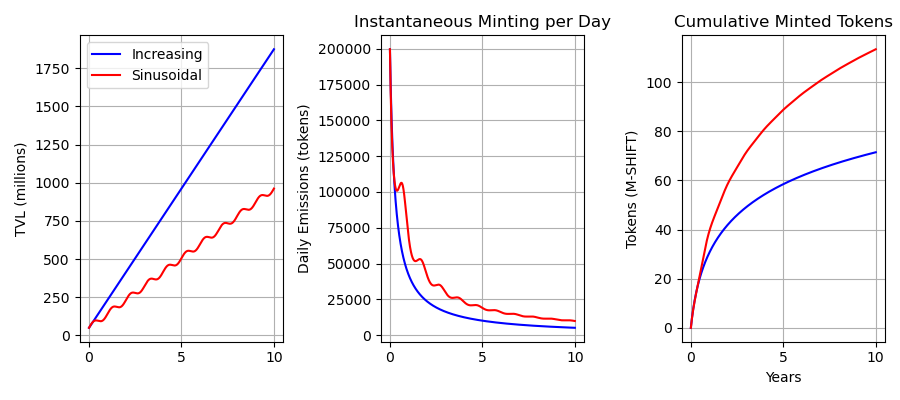

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Constants
CAP = 2.5e9  # 2.5B hard cap
start_tvl = 50e6  # 50 M-csUSD
delta_max = 100e6  # max tokens per day
E0 = 2000  # initial emission (tokens per day)
alpha = 1e-5
print(f"alpha: {alpha}")

# Create epochs (days)
days = 365 * 10  # 10 years
epochs = np.linspace(0, days-1, days)  # One point per day for 10 years

# TVL trajectory functions
def increasing_tvl(t, start=start_tvl, growth_rate=0.01):
    return start * (1 + growth_rate * t)

def sinusoidal_increasing_tvl(t, start=start_tvl, growth_rate=0.005, amplitude=2e7, period=365):
    trend = start * (1 + growth_rate * t)
    seasonal = amplitude * np.sin(2 * np.pi * t / period)
    return trend + seasonal

# Calculate emissions for a given TVL trajectory
def calculate_emissions(tvl_trajectory):
    tvl_values = tvl_trajectory(epochs)
    minted_so_far = np.zeros_like(epochs)
    emissions = np.zeros_like(epochs)
    
    for t in range(len(epochs)):
        # Cap remaining factor
        g_cap = 1 - minted_so_far[t] / CAP
        
        # Inverse TVL factor
        f_tvl = 1 / (1 + alpha * tvl_values[t])
        
        # Provisional emission
        E_t = delta_max * g_cap * f_tvl
        
        # Hard cap enforcement
        E_actual = min(E_t, CAP - minted_so_far[t])
        emissions[t] = E_actual
        
        # Update minted so far for next epoch
        if t < len(epochs) - 1:
            minted_so_far[t + 1] = minted_so_far[t] + E_actual
    
    return tvl_values, emissions, minted_so_far

# Create figure with subplots
# plt.figure(figsize=(15, 12))
# gs = GridSpec(3, 2, height_ratios=[1, 1, 1])
fig, axx = plt.subplots(figsize=(9, 4), nrows=1, ncols=3)

# List of TVL trajectories with their labels
trajectories = [
    (increasing_tvl, "Increasing"),
    (sinusoidal_increasing_tvl, "Sinusoidal")
]

# Calculate and plot each trajectory
colors = ['b', 'r', 'g']
for col, (tvl_func, label) in enumerate(trajectories):
    tvl_values, emissions, minted_so_far = calculate_emissions(tvl_func)
    print(minted_so_far)
    
    # Plot TVL trajectory
    ax1 = axx[0]
    ax1.plot(epochs/365, tvl_values/1e6, colors[col], label=label)
    ax1.set_ylabel('TVL (millions)')
    ax1.grid(True)
    
    # Plot daily emissions
    ax2 = axx[1]
    ax2.plot(epochs/365, emissions, colors[col])
    ax2.set_ylabel('Daily Emissions (tokens)')
    ax2.set_title('Instantaneous Minting per Day')
    ax2.grid(True)
    
    # Plot cumulative emissions
    ax3 = axx[2]
    ax3.plot(epochs/365, minted_so_far/1e6, colors[col])
    ax3.set_ylabel('Tokens (M-SHIFT)')
    ax3.set_xlabel('Years')
    ax3.set_title('Cumulative Minted Tokens')
    ax3.grid(True)
    
# Add cap line to cumulative plot
ax1.legend()
# ax3.axhline(y=CAP/1e6, color='r', linestyle='--', alpha=0.7, label='Hard Cap (2.5B)')
# ax3.legend()
# ax3.set_yscale('log')

plt.tight_layout()
plt.savefig('tvl_emissions_visualization.png', dpi=300)
plt.show()